In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os

import cv2

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.applications import Xception, ResNet50V2, InceptionV3
from tensorflow.keras.layers import Flatten, Dense, Dropout
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix

# Dataset description and EDA

Dataset link: https://www.kaggle.com/datasets/trainingdatapro/computed-tomography-ct-of-the-brain

In [47]:
dataset_path = "/content/drive/MyDrive/storage extension/Colab Notebooks/CSE463/Lab 4/23341134_UdoySaha_Lab4/Dataset"

dataframe = pd.read_csv(os.path.join(dataset_path, "ct_brain.csv"))
dataframe

,dcm,jpg,type
0,/aneurysm/0.dcm,/aneurysm/0.jpg,aneurysm
1,/aneurysm/1.dcm,/aneurysm/1.jpg,aneurysm
2,/aneurysm/2.dcm,/aneurysm/2.jpg,aneurysm
3,/aneurysm/3.dcm,/aneurysm/3.jpg,aneurysm
4,/aneurysm/4.dcm,/aneurysm/4.jpg,aneurysm
...,...,...,...
251,/cancer/86.dcm,/cancer/86.jpg,cancer
252,/cancer/87.dcm,/cancer/87.jpg,cancer
253,/cancer/88.dcm,/cancer/88.jpg,cancer
254,/cancer/89.dcm,/cancer/89.jpg,cancer


In [48]:
# Dataset size
print(dataframe.shape)

(256, 3)




---

So, there are 256 images in total.

---

In [49]:
# Number of classes
classes = dataframe["type"].unique()
print(classes)

no_of_classes = len(classes)

['aneurysm' 'tumor' 'cancer']




---

There are 3 classes in total.

---

In [50]:
no_of_classes

3

In [51]:
# dcm file types are unnecessary
dataframe.drop(['dcm'], inplace = True, axis = 1)
dataframe

,jpg,type
0,/aneurysm/0.jpg,aneurysm
1,/aneurysm/1.jpg,aneurysm
2,/aneurysm/2.jpg,aneurysm
3,/aneurysm/3.jpg,aneurysm
4,/aneurysm/4.jpg,aneurysm
...,...,...
251,/cancer/86.jpg,cancer
252,/cancer/87.jpg,cancer
253,/cancer/88.jpg,cancer
254,/cancer/89.jpg,cancer


In [52]:
# Check for any null or duplicate values
dataframe.describe()

,jpg,type
count,256,256
unique,256,3
top,/aneurysm/0.jpg,cancer
freq,1,90


# Loading data and preprocessing

In [53]:
# Load and preprocess image data
def load_and_preprocess_data(data_dir, classes, target_shape=(224, 224)):
    data = []
    labels = []

    for i, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, "files", class_name)
        for filename in os.listdir(class_dir):
            if filename.endswith('.jpg'):
                file_path = os.path.join(class_dir, filename)
                img = cv2.imread(file_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, target_shape)
                img = img / 255.0
                # random rotation
                angle = np.random.randint(-10, 10)
                M = cv2.getRotationMatrix2D((target_shape[0] / 2, target_shape[1] / 2), angle, 1)
                img_array = cv2.warpAffine(img, M, target_shape)
                # random flip
                if np.random.rand() > 0.5:
                    img_array = cv2.flip(img_array, 1)

                data.append(img)
                labels.append(i)

    return np.array(data), np.array(labels)


# Split data into training and testing sets
data, labels = load_and_preprocess_data(dataset_path, classes)
labels = to_categorical(labels, num_classes=len(classes))  # Convert labels to one-hot encoding

# 80% training data
X_train, X_test_val, y_train, y_test_val = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)
# 10% test and 10% val
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=42, stratify=y_test_val)

In [54]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(207, 224, 224, 3) (207, 3)
(26, 224, 224, 3) (26, 3)
(26, 224, 224, 3) (26, 3)


[84. 84. 91.]


Text(0.5, 1.0, 'Distribution of classes in the entire dataset')

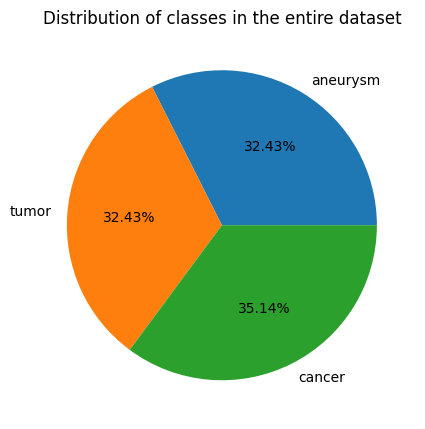

In [55]:
print(labels.sum(axis=0))

# plot this into a pie chart
plt.rcParams['figure.figsize'] = (5, 10)
plt.pie(labels.sum(axis=0), labels=classes, autopct='%1.2f%%')
plt.title("Distribution of classes in the entire dataset")

Train [67. 67. 73.]
Test [9. 8. 9.]
Val [8. 9. 9.]


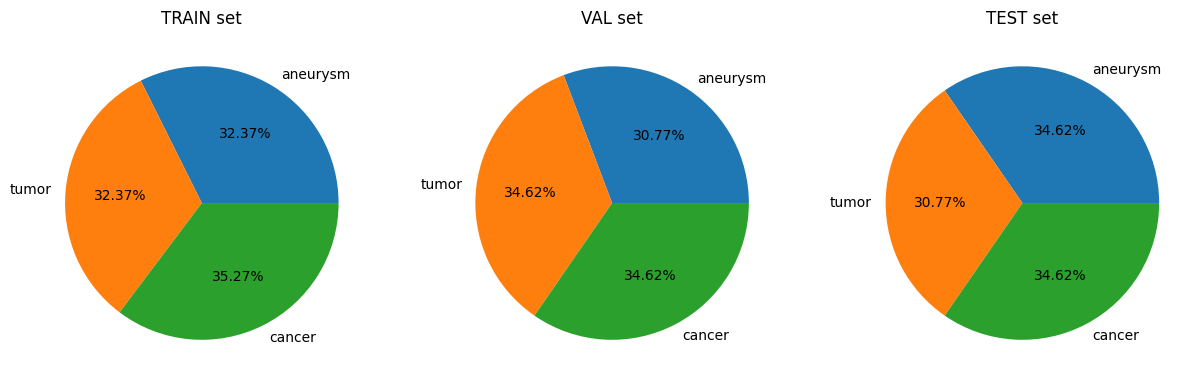

In [56]:
print("Train", y_train.sum(axis=0))
print("Test", y_test.sum(axis=0))
print("Val", y_val.sum(axis=0))

plt.rcParams['figure.figsize'] = (15, 5)

plt.subplot(1, 3, 1)
plt.pie(y_train.sum(axis=0), labels=classes, autopct='%1.2f%%')
plt.title("TRAIN set")

plt.subplot(1, 3, 2)
plt.pie(y_val.sum(axis=0), labels=classes, autopct='%1.2f%%')
plt.title("VAL set")

plt.subplot(1, 3, 3)
plt.pie(y_test.sum(axis=0), labels=classes, autopct='%1.2f%%')
plt.title("TEST set")

plt.show()

# Model implementation


---


Using:
- Xception
- ResNet50V2
- InceptionV3


---



## Using Xception

In [57]:
input_shape = X_train[0].shape

Xception_base = Xception(weights='imagenet', include_top=False, input_shape=input_shape)

trainable = False

for i, layer in enumerate(Xception_base.layers):
    if i == len(Xception_base.layers) - 17:
      trainable = True
    layer.trainable = trainable

for layer in Xception_base.layers:
    print(layer.name, layer.trainable)

Xception_base.summary()

input_layer_4 False
block1_conv1 False
block1_conv1_bn False
block1_conv1_act False
block1_conv2 False
block1_conv2_bn False
block1_conv2_act False
block2_sepconv1 False
block2_sepconv1_bn False
block2_sepconv2_act False
block2_sepconv2 False
block2_sepconv2_bn False
conv2d_102 False
block2_pool False
batch_normalization_105 False
add_24 False
block3_sepconv1_act False
block3_sepconv1 False
block3_sepconv1_bn False
block3_sepconv2_act False
block3_sepconv2 False
block3_sepconv2_bn False
conv2d_103 False
block3_pool False
batch_normalization_106 False
add_25 False
block4_sepconv1_act False
block4_sepconv1 False
block4_sepconv1_bn False
block4_sepconv2_act False
block4_sepconv2 False
block4_sepconv2_bn False
conv2d_104 False
block4_pool False
batch_normalization_107 False
add_26 False
block5_sepconv1_act False
block5_sepconv1 False
block5_sepconv1_bn False
block5_sepconv2_act False
block5_sepconv2 False
block5_sepconv2_bn False
block5_sepconv3_act False
block5_sepconv3 False
block5_sepco

Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 111, 111, 32)   │            864 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 111, 111, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 111, 111, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 109, 109, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 109, 109, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 109, 109, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 109, 109, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 109, 109, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 109, 109, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_102 (Conv2D)       │ (None, 55, 55, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 55, 55, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 6,788,384 (25.90 MB)

 Non-trainable params: 14,073,096 (53.68 MB)

In [58]:
# Add custom layers on top
x = Flatten()(Xception_base.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
output_layer = Dense(len(classes), activation='softmax')(x)  # Output layer for classification

# Create the complete model
Xception_model = Model(inputs=Xception_base.input, outputs=output_layer)

In [59]:
# Assuming `y_train_original` holds the non-one-hot encoded original sentiment labels
y_train_original = np.argmax(y_train, axis=1)  # Converting one-hot encoded y_train back to label form

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_original), y=y_train_original)
class_weights = dict(enumerate(class_weights))

num_epochs = 10

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_Xception_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stop = EarlyStopping(monitor='val_loss', patience=10)

Xception_model.compile(loss = 'categorical_crossentropy',
              optimizer=Adam(learning_rate=0.002, clipnorm=1.0),
              metrics = ['accuracy'])

history = Xception_model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    epochs=num_epochs,
                    class_weight=class_weights,
                    callbacks =[reduce_lr, early_stop, checkpoint],
                    batch_size=32,
                    verbose=1)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 947ms/step - accuracy: 0.4520 - loss: 7.5574
Epoch 1: val_accuracy improved from -inf to 0.69231, saving model to best_Xception_model.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 66s 9s/step - accuracy: 0.4722 - loss: 7.2997 - val_accuracy: 0.6923 - val_loss: 3.2859 - learning_rate: 0.0020
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9518 - loss: 0.1801
Epoch 2: val_accuracy improved from 0.69231 to 0.96154, saving model to best_Xception_model.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 69s 8s/step - accuracy: 0.9500 - loss: 0.1835 - val_accuracy: 0.9615 - val_loss: 0.6319 - learning_rate: 0.0020
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.9807 - loss: 0.0529
Epoch 3: val_accuracy improved from 0.96154 to 1.00000, saving model to best_Xception_model.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 81s 8s/step - accuracy: 0.9801 - loss: 0.0559 - val_accuracy: 1.0000 - val_loss: 2.6593e-07 - learning_rate: 0.0020
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 149

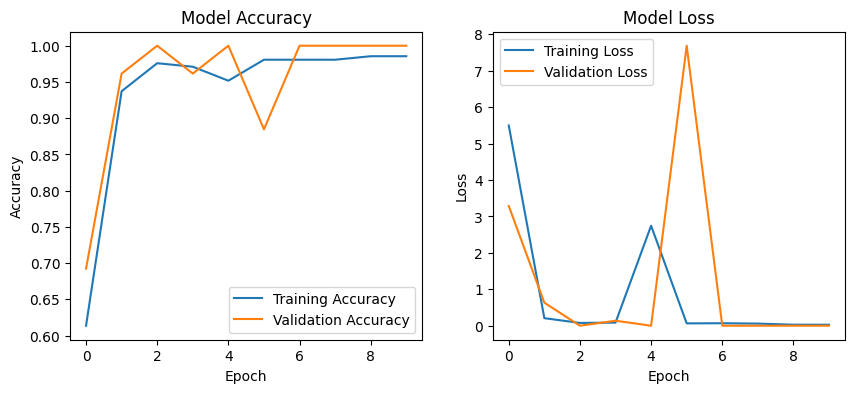

In [60]:
plt.rcParams['figure.figsize'] = (10, 4)

# Plotting accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Using ResNet50V2

In [72]:
input_shape = X_train[0].shape

ResNet50V2_base = ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)

trainable = False

for i, layer in enumerate(ResNet50V2_base.layers):
    if i == len(ResNet50V2_base.layers) - 36:
      trainable = True
    layer.trainable = trainable

for layer in ResNet50V2_base.layers:
    print(layer.name, layer.trainable)

ResNet50V2_base.summary()

input_layer_7 False
conv1_pad False
conv1_conv False
pool1_pad False
pool1_pool False
conv2_block1_preact_bn False
conv2_block1_preact_relu False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_pad False
conv2_block1_2_conv False
conv2_block1_2_bn False
conv2_block1_2_relu False
conv2_block1_0_conv False
conv2_block1_3_conv False
conv2_block1_out False
conv2_block2_preact_bn False
conv2_block2_preact_relu False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_pad False
conv2_block2_2_conv False
conv2_block2_2_bn False
conv2_block2_2_relu False
conv2_block2_3_conv False
conv2_block2_out False
conv2_block3_preact_bn False
conv2_block3_preact_relu False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_pad False
conv2_block3_2_conv False
conv2_block3_2_bn False
conv2_block3_2_relu False
max_pooling2d_14 False
conv2_block3_3_conv False
conv2_block3_out False
conv3_b

Model: "resnet50v2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 56, 56, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 56, 56, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 58, 58, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv  

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 14,970,880 (57.11 MB)

 Non-trainable params: 8,593,920 (32.78 MB)

In [73]:
# Add custom layers on top
x = Flatten()(ResNet50V2_base.output)
x = Dropout(0.7)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.7)(x)
x = Dense(256, activation='relu')(x)
output_layer = Dense(len(classes), activation='softmax')(x)  # Output layer for classification

# Create the complete model
ResNet50V2_model = Model(inputs=ResNet50V2_base.input, outputs=output_layer)

In [74]:
# Assuming `y_train_original` holds the non-one-hot encoded original sentiment labels
y_train_original = np.argmax(y_train, axis=1)  # Converting one-hot encoded y_train back to label form

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_original), y=y_train_original)
class_weights = dict(enumerate(class_weights))

num_epochs = 10

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_ResNet50V2_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stop = EarlyStopping(monitor='val_loss', patience=10)

ResNet50V2_model.compile(loss = 'categorical_crossentropy',
              optimizer=Adam(learning_rate=0.002, clipnorm=1.0),
              metrics = ['accuracy'])

history = ResNet50V2_model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    epochs=num_epochs,
                    class_weight=class_weights,
                    callbacks =[reduce_lr, early_stop, checkpoint],
                    batch_size=32,
                    verbose=1)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4345 - loss: 9.0234   


Epoch 1: val_accuracy improved from -inf to 0.34615, saving model to best_ResNet50V2_model.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 151s 22s/step - accuracy: 0.4593 - loss: 8.6580 - val_accuracy: 0.3462 - val_loss: 889.6722 - learning_rate: 0.0020
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9554 - loss: 0.2618
Epoch 2: val_accuracy improved from 0.34615 to 0.61538, saving model to best_ResNet50V2_model.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 125s 21s/step - accuracy: 0.9562 - loss: 0.2598 - val_accuracy: 0.6154 - val_loss: 12837.6504 - learning_rate: 0.0020
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9547 - loss: 1.3577
Epoch 3: val_accuracy did not improve from 0.61538
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 129ms/step - accuracy: 0.9561 - loss: 1.3097 - val_accuracy: 0.3846 - val_loss: 184151.0625 - learning_rate: 0.0020
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9703 - loss: 0.0871
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.000400000018998

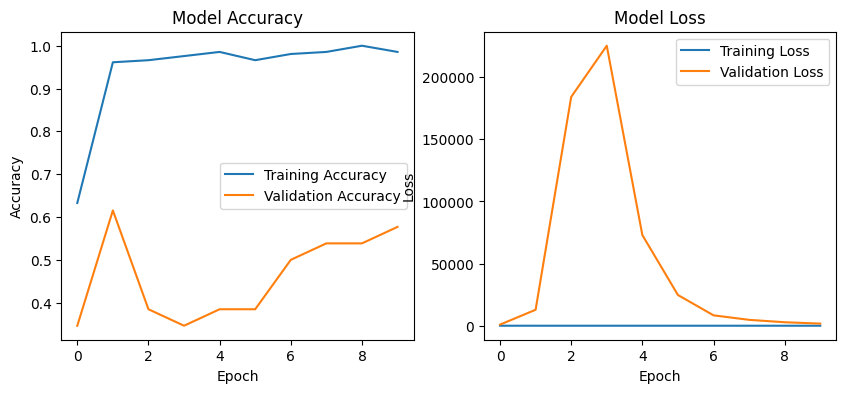

In [75]:
plt.rcParams['figure.figsize'] = (10, 4)

# Plotting accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Using InceptionV3

In [65]:
input_shape = X_train[0].shape

InceptionV3_base = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

trainable = False

for i, layer in enumerate(InceptionV3_base.layers):
    if i == len(InceptionV3_base.layers) - 22:
      trainable = True
    layer.trainable = trainable

for layer in InceptionV3_base.layers:
    print(layer.name, layer.trainable)

InceptionV3_base.summary()

input_layer_6 False
conv2d_106 False
batch_normalization_109 False
activation_94 False
conv2d_107 False
batch_normalization_110 False
activation_95 False
conv2d_108 False
batch_normalization_111 False
activation_96 False
max_pooling2d_10 False
conv2d_109 False
batch_normalization_112 False
activation_97 False
conv2d_110 False
batch_normalization_113 False
activation_98 False
max_pooling2d_11 False
conv2d_114 False
batch_normalization_117 False
activation_102 False
conv2d_112 False
conv2d_115 False
batch_normalization_115 False
batch_normalization_118 False
activation_100 False
activation_103 False
average_pooling2d_9 False
conv2d_111 False
conv2d_113 False
conv2d_116 False
conv2d_117 False
batch_normalization_114 False
batch_normalization_116 False
batch_normalization_119 False
batch_normalization_120 False
activation_99 False
activation_101 False
activation_104 False
activation_105 False
mixed0 False
conv2d_121 False
batch_normalization_124 False
activation_109 False
conv2d_119 False


Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_106 (Conv2D)       │ (None, 111, 111, 32)   │            864 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_109   │ (None, 111, 111, 32)   │             96 │ conv2d_106[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_94             │ (None, 111, 111, 32)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_107 (Conv2D)       │ (None, 109, 109, 32)   │          9,216 │ activation_94[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_110   │ (None, 109, 109, 32)   │             96 │ conv2d_107[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_95             │ (None, 109, 109, 32)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_108 (Conv2D)       │ (None, 109, 109, 64)   │         18,432 │ activation_95[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_111   │ (None, 109, 109, 64)   │            192 │ conv2d_108[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_96             │ (None, 109, 109, 64)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_10          │ (None, 54, 54, 64)     │              0 │ activation_96[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_109 (Conv2D)       │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d_10[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_112   │ (None, 54, 54, 80)     │            240 │ conv2d_109[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_97             │ (None, 54, 54, 80)     │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_110 (Conv2D)  

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 2,820,096 (10.76 MB)

 Non-trainable params: 18,982,688 (72.41 MB)

In [66]:
# Add custom layers on top
x = Flatten()(InceptionV3_base.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
output_layer = Dense(len(classes), activation='softmax')(x)  # Output layer for classification

# Create the complete model
InceptionV3_model = Model(inputs=InceptionV3_base.input, outputs=output_layer)

In [67]:
# Assuming `y_train_original` holds the non-one-hot encoded original sentiment labels
y_train_original = np.argmax(y_train, axis=1)  # Converting one-hot encoded y_train back to label form

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_original), y=y_train_original)
class_weights = dict(enumerate(class_weights))

num_epochs = 10

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_InceptionV3_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stop = EarlyStopping(monitor='val_loss', patience=10)

InceptionV3_model.compile(loss = 'categorical_crossentropy',
              optimizer=Adam(learning_rate=0.002, clipnorm=1.0),
              metrics = ['accuracy'])

history = InceptionV3_model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    epochs=num_epochs,
                    class_weight=class_weights,
                    callbacks =[reduce_lr, early_stop, checkpoint],
                    batch_size=32,
                    verbose=1)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4502 - loss: 26.8954  
Epoch 1: val_accuracy improved from -inf to 0.73077, saving model to best_InceptionV3_model.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 51s 6s/step - accuracy: 0.4585 - loss: 27.4858 - val_accuracy: 0.7308 - val_loss: 7.4933 - learning_rate: 0.0020
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8421 - loss: 2.8782
Epoch 2: val_accuracy improved from 0.73077 to 0.92308, saving model to best_InceptionV3_model.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step - accuracy: 0.8473 - loss: 2.7454 - val_accuracy: 0.9231 - val_loss: 2.2491 - learning_rate: 0.0020
Epoch 3/10
6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9931 - loss: 0.3434
Epoch 3: val_accuracy improved from 0.92308 to 1.00000, saving model to best_InceptionV3_model.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.9864 - loss: 0.6946 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 0.0020
Epoch 4/10
6/7 ━━━━━━━━━━━━━━━━━━━

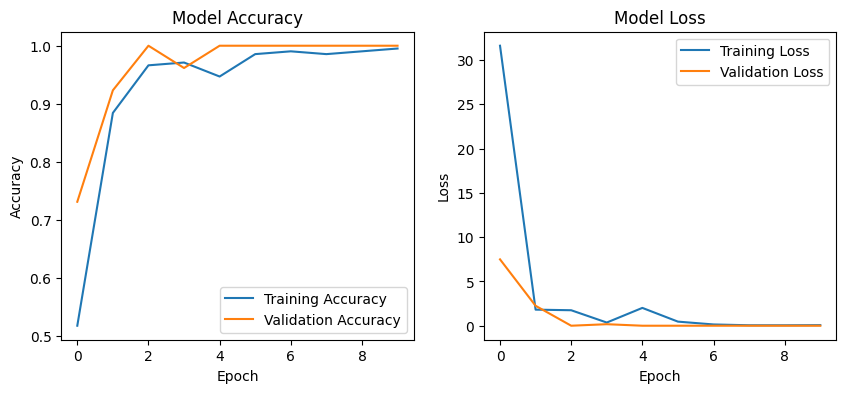

In [68]:
plt.rcParams['figure.figsize'] = (10, 4)

# Plotting accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Model evaluation

For Xception model
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.7692 - loss: 19.4326
Test accuracy: 0.7692307829856873
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


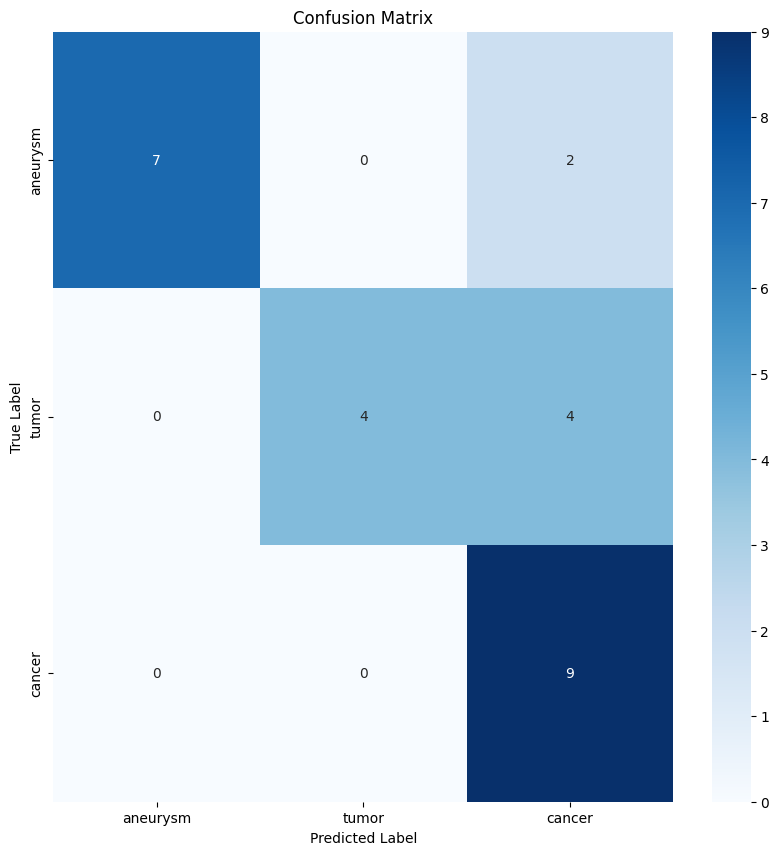

              precision    recall  f1-score   support

    aneurysm       1.00      0.78      0.88         9
       tumor       1.00      0.50      0.67         8
      cancer       0.60      1.00      0.75         9

    accuracy                           0.77        26
   macro avg       0.87      0.76      0.76        26
weighted avg       0.86      0.77      0.77        26



In [69]:
print("For Xception model")

model = load_model('best_Xception_model.keras')

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f'Test accuracy: {test_accuracy}')

# Predict the labels for test data
y_pred = np.argmax(model.predict(X_test), axis=-1)
y_true = np.argmax(y_test, axis=-1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
# cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=classes))

For ResNet50V2 model
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.6154 - loss: 9778.7500
Test accuracy: 0.6153846383094788


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


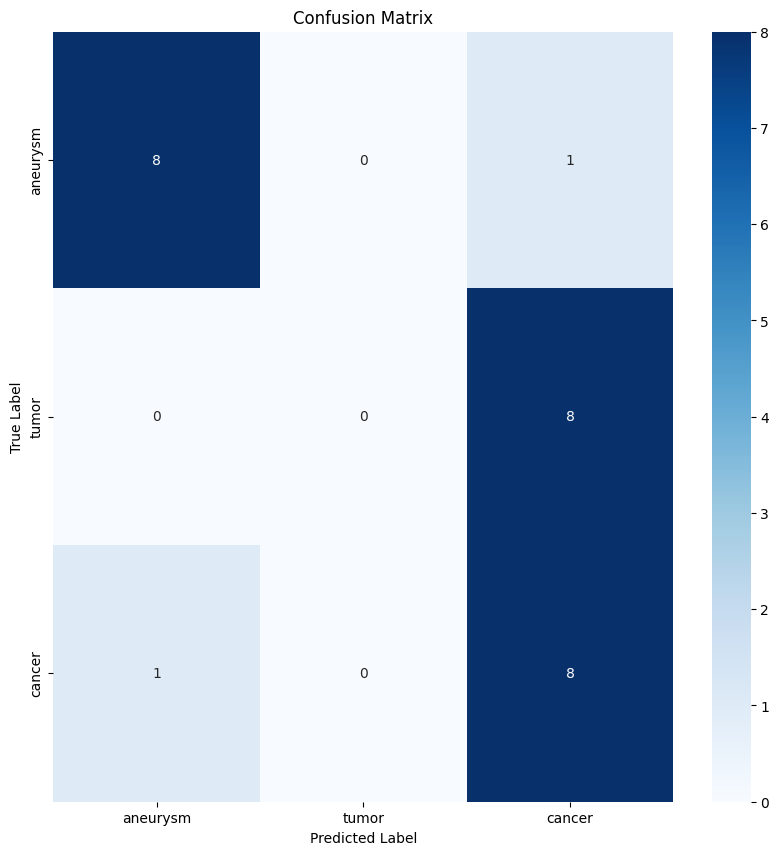

              precision    recall  f1-score   support

    aneurysm       0.89      0.89      0.89         9
       tumor       0.00      0.00      0.00         8
      cancer       0.47      0.89      0.62         9

    accuracy                           0.62        26
   macro avg       0.45      0.59      0.50        26
weighted avg       0.47      0.62      0.52        26



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [76]:
print("For ResNet50V2 model")

model = load_model('best_ResNet50V2_model.keras')

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f'Test accuracy: {test_accuracy}')

# Predict the labels for test data
y_pred = np.argmax(model.predict(X_test), axis=-1)
y_true = np.argmax(y_test, axis=-1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
# cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=classes))

For InceptionV3 model
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.9231 - loss: 2.8392
Test accuracy: 0.9230769276618958


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


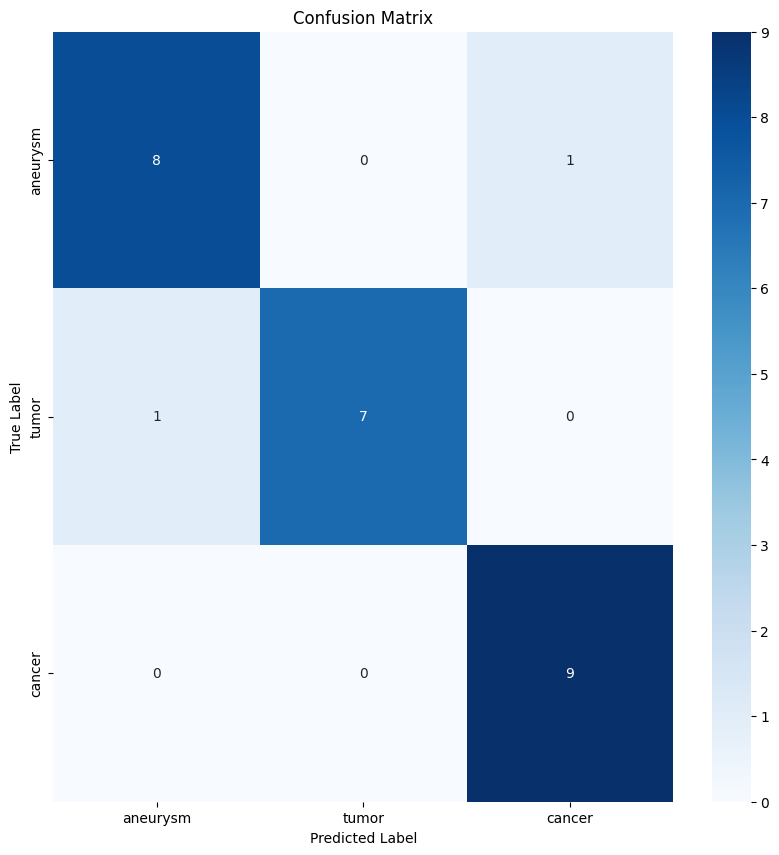

              precision    recall  f1-score   support

    aneurysm       0.89      0.89      0.89         9
       tumor       1.00      0.88      0.93         8
      cancer       0.90      1.00      0.95         9

    accuracy                           0.92        26
   macro avg       0.93      0.92      0.92        26
weighted avg       0.93      0.92      0.92        26



In [71]:
print("For InceptionV3 model")

model = load_model('best_InceptionV3_model.keras')

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f'Test accuracy: {test_accuracy}')

# Predict the labels for test data
y_pred = np.argmax(model.predict(X_test), axis=-1)
y_true = np.argmax(y_test, axis=-1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
# cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=classes))

# Comparison

The accuracy of the 3 models are:
- Xception -> 76.9%
- ResNet50V2 -> 61.5%
- InceptionV3 -> 92.3%

Therefore, InceptionV3 model worked the best in this case.

The first reason is, the models were trained only for 10 epochs. After running more epochs (200 ish), the scenerio might change.

Secondly, Xception was slighly overfit. The ResNet50V2 was very much overfit even after using extra Dropout layers. So, these models might be too complex for our dataset.